<a href="https://colab.research.google.com/github/anpendyal/CNN-Cancer-Research-2021/blob/main/ResNet50_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dataset from https://www.kaggle.com/paultimothymooney/breast-histopathology-images 

In [ ]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten,Conv2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
from tensorflow.keras.layers import MaxPooling2D

In [ ]:
import tensorflow as tf

#resize images to 224 by 224
IMAGE_SIZE = [224, 224]

#specifying paths to dataset
train_path = "/content/drive/MyDrive/Train Set"
val_path = "/content/drive/MyDrive/Validation Set"
test_path = "/content/drive/MyDrive/Test Set"

In [ ]:
resnet50 = ResNet50(input_shape = IMAGE_SIZE + [3], weights = "imagenet", include_top = False)

In [ ]:
resnet50.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [ ]:
for layer in resnet50.layers:
  layer.trainable = False

In [ ]:
from glob import glob
#get number of classes from training set
folders = glob("/content/drive/MyDrive/Train Set/*")
len(folders)

2

In [ ]:
x = Flatten()(resnet50.output)

In [ ]:
#output layer
prediction = Dense(len(folders), activation = "sigmoid")(x)

#create a model object
model = Model(inputs = resnet50.input, outputs = prediction)

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [ ]:
#specify loss, optimizer, and metrics
model.compile(
    loss = "binary_crossentropy",
    optimizer = "adam",
    metrics = [
               "accuracy",
                tf.keras.metrics.BinaryAccuracy(),
                tf.keras.metrics.AUC(from_logits=True),
                tf.keras.metrics.Precision(),
                tf.keras.metrics.Recall(),
                tf.keras.metrics.TruePositives(),
                tf.keras.metrics.TrueNegatives(),
                tf.keras.metrics.FalsePositives(),
                tf.keras.metrics.FalseNegatives()
               ]
)

In [ ]:
#use image data generator to import the images from the dataset
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#rescale RGB values in images to be between 0-1
train_datagen = ImageDataGenerator(rescale = 1./255)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [ ]:
#same target size as initialized for images
training_set = train_datagen.flow_from_directory("/content/drive/MyDrive/Train Set",
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = "categorical")

Found 25975 images belonging to 2 classes.


In [ ]:
validation_set = train_datagen.flow_from_directory("/content/drive/MyDrive/Validation Set",
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = "categorical")

Found 977 images belonging to 2 classes.


In [ ]:
test_set = test_datagen.flow_from_directory("/content/drive/MyDrive/Test Set",
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = "categorical")

Found 957 images belonging to 2 classes.


In [ ]:
from keras.callbacks import EarlyStopping

#early stopping set to a patience of 5 due to time constraints
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 5)

history = model.fit(
    training_set,
    validation_data = validation_set,
    epochs = 50,
    #steps_per_epoch = len(training_set),
    #validation_steps = len(validation_set),
    callbacks = [early_stopping]
)

Epoch 1/50
812/812 [==============================] - 5521s 7s/step - loss: 0.6660 - accuracy: 0.6669 - binary_accuracy: 0.6668 - auc: 0.7273 - precision: 0.6666 - recall: 0.6674 - true_positives: 17337.0000 - true_negatives: 17303.0000 - false_positives: 8672.0000 - false_negatives: 8638.0000 - val_loss: 0.5300 - val_accuracy: 0.7390 - val_binary_accuracy: 0.7385 - val_auc: 0.8157 - val_precision: 0.7382 - val_recall: 0.7390 - val_true_positives: 722.0000 - val_true_negatives: 721.0000 - val_false_positives: 256.0000 - val_false_negatives: 255.0000
Epoch 2/50
812/812 [==============================] - 83s 102ms/step - loss: 0.6237 - accuracy: 0.7045 - binary_accuracy: 0.7041 - auc: 0.7721 - precision: 0.7042 - recall: 0.7040 - true_positives: 18286.0000 - true_negatives: 18294.0000 - false_positives: 7681.0000 - false_negatives: 7689.0000 - val_loss: 0.7541 - val_accuracy: 0.6213 - val_binary_accuracy: 0.6203 - val_auc: 0.7278 - val_precision: 0.6198 - val_recall: 0.6223 - val_true_po

15

In [ ]:
#evaluate model on test set
from sklearn.metrics import roc_curve, auc
model.evaluate(test_set, verbose=1)

30/30 [==============================] - 177s 6s/step - loss: 0.6097 - accuracy: 0.6761 - binary_accuracy: 0.6755 - auc: 0.7584 - precision: 0.6746 - recall: 0.6782 - true_positives: 649.0000 - true_negatives: 644.0000 - false_positives: 313.0000 - false_negatives: 308.0000


[0.609695553779602,
 0.676071047782898,
 0.6755486130714417,
 0.7584498524665833,
 0.67463618516922,
 0.6781609058380127,
 649.0,
 644.0,
 313.0,
 308.0]

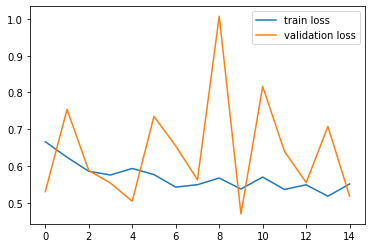

<Figure size 432x288 with 0 Axes>

In [ ]:
#plot loss
import matplotlib.pyplot as plt
plt.plot(history.history["loss"], label = "train loss")
plt.plot(history.history["val_loss"], label = "validation loss")
plt.legend()
plt.show()
plt.savefig("LossVal_loss")

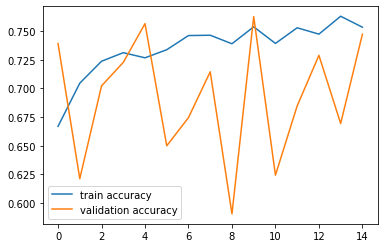

<Figure size 432x288 with 0 Axes>

In [ ]:
#plot accuracy
plt.plot(history.history["accuracy"], label = "train accuracy")
plt.plot(history.history["val_accuracy"], label = "validation accuracy")
plt.legend()
plt.show()
plt.savefig("AccVal_acc")